# Plotting slices of the vertical coordinates in domain_cfg.nc

The idea of this notebook is to extract a hyperslab of information from the domain_cfg.nc and plot it up in a matplotlib figure.

This presents an x-z or y-z section plot coloured by stiffness.
Just replace stiffness variable for T/S etc.

author: jdha
1 May 2018



In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
%matplotlib inline

In [8]:
# Configuration File

file_cfg = '/projectsa/Eurobasin/d_sub.nc'

# Bathymetry File

file_bth = '/projectsa/Eurobasin/b_sub.nc'

In [5]:
def plot_zgr(f_cfg, f_bth, i_coords, j_coords, sig_lev, ylim):
    
    # need to write in a check that either i or j are single values
    
    rootgrp = Dataset(f_cfg, "r", format="NETCDF4")
    e3t_0   = np.squeeze(rootgrp.variables['e3t_0'][:,:,j_coords,i_coords])
    e3w_0   = np.squeeze(rootgrp.variables['e3w_0'][:,:,j_coords,i_coords])
    e3t_1d  = np.squeeze(rootgrp.variables['e3t_1d'][:,:])
    e3w_1d  = np.squeeze(rootgrp.variables['e3w_1d'][:,:])
    stiff   = np.squeeze(rootgrp.variables['stiffness'][:,j_coords,i_coords])
    m       = np.squeeze(rootgrp.variables['bottom_level'][:,j_coords,i_coords])
    
    mv      = np.copy(m)
    mv[0:-1]= np.minimum(m[0:-1],m[1:])
    
    jpk = len(e3t_0[:,0])
    jpi = np.max(m.shape)
    
    if len(i_coords)==1:
        e3v_0   = np.squeeze(rootgrp.variables['e3v_0' ][:,:,j_coords,i_coords])
        e3vw_0  = np.squeeze(rootgrp.variables['e3vw_0'][:,:,j_coords,i_coords])
        coords  = j_coords
    elif len(j_coords)==1:
        e3v_0   = np.squeeze(rootgrp.variables['e3u_0' ][:,:,j_coords,i_coords])
        e3vw_0  = np.squeeze(rootgrp.variables['e3uw_0'][:,:,j_coords,i_coords])
        coords  = i_coords
    else:
        raise Exception('Problem with input coordinates.')
              
    gdept   , gdepw     = e3_to_depth( e3t_0,  e3w_0, jpk)
    gdepv   , gdepvw    = e3_to_depth( e3v_0, e3vw_0, jpk)
    gdept_1d, gdepw_1d  = e3_to_depth(e3t_1d[:,np.newaxis], e3w_1d[:,np.newaxis], jpk)
    
    rootgrp.close()
    
    # read in bathymetry
    
    rootgrp = Dataset(f_bth, "r", format="NETCDF4")
    bathy   = np.squeeze(rootgrp.variables['Bathymetry'][j_coords,i_coords])
    rootgrp.close()
    
    if adj == True:
        
        m, gdept, gdepw = adjust_zgr(m,bathy,gdept,gdepw,sig_lev,gdept_1d,gdepw_1d)
        
        # update gdepvw
        for i in range(jpi-1):
            gdepvw[:,i] = ( gdepw[:,i] + gdepw[:,i+1] ) / 2.
        
        
        #need to recalc stiffness now
        
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

    plt.sca(ax)
   
    bathy_patch = Polygon(np.vstack((np.hstack( (coords[0], coords, coords[-1]) ),
                                     np.hstack( (np.amax(bathy[:]), bathy, np.amax(bathy[:])) ))).T,
                          closed=True,
                          facecolor=(0.8,0.8,0), alpha=0.1, edgecolor=None)

    # Add patch to axes
    ax.add_patch(bathy_patch)
    patches = []
    colors = []
    
    
    for i in range(jpi-1):
        
        k = np.min((jpk-2,m[i+1]-1))
        
        if k >= sig_lev:
            
            x = [coords[i+1]-0.5, coords[i+1], coords[i+1]+0.5, 
                 coords[i+1]+0.5, coords[i+1], coords[i+1]-0.5, coords[i+1]-0.5]
            y = [gdepw[k+1,i+1], gdepw[k+1,i+1], gdepw[k+1,i+1],
                 gdepw[sig_lev,i+1], gdepw[sig_lev,i+1], gdepw[sig_lev,i+1], gdepw[k+1,i+1]]
            
            polygon = Polygon(np.vstack((x,y)).T, True)
            patches.append(polygon)
            colors = np.append(colors,stiff[i+1]) 
    
        k = np.min((sig_lev-1,m[i+1]-1))
        
        x = [coords[i+1]-0.5, coords[i+1], coords[i+1]+0.5, 
             coords[i+1]+0.5, coords[i+1], coords[i+1]-0.5, coords[i+1]-0.5]
        y = [gdepvw[k+1,i], gdepw[k+1,i+1], gdepvw[k+1,i+1],
             gdepvw[0,i+1], gdepw[0,i+1], gdepvw[0,i], gdepvw[k+1,i]]

        polygon = Polygon(np.vstack((x,y)).T, True)
        patches.append(polygon)
        colors = np.append(colors,stiff[i+1])
       
    # hbatt plotting
    for i in range(jpi-1):
        for k in np.arange(np.min((jpk-2,sig_lev-1)),-1,-1):
        
            x = [coords[i+1]-0.5, coords[i+1], coords[i+1]+0.5, 
                 coords[i+1]+0.5, coords[i+1], coords[i+1]-0.5, coords[i+1]-0.5]
            y = [gdepvw[k+1,i], gdepw[k+1,i+1], gdepvw[k+1,i+1],
                 gdepvw[k,i+1], gdepw[k,i+1], gdepvw[k,i], gdepvw[k+1,i]]
            plt.plot(x,y,color=(0.7,0.7,0.7),linewidth=0.1)
            plt.plot(coords[i+1], gdept[k,i+1],'.',markersize=1,color=(0.7,0.7,0.7))
    
    # zps plotting up to sig_lev
    for i in range(jpi-1):
        for k in np.arange(np.min((jpk-2,m[i+1]-1)),sig_lev-1,-1):
        
            x = [coords[i+1]-0.5, coords[i+1], coords[i+1]+0.5, 
                 coords[i+1]+0.5, coords[i+1], coords[i+1]-0.5, coords[i+1]-0.5]
            y = [gdepw[k+1,i+1], gdepw[k+1,i+1], gdepw[k+1,i+1],
                 gdepw[k,i+1], gdepw[k,i+1], gdepw[k,i+1], gdepw[k+1,i+1]]
            plt.plot(x,y,'k-',linewidth=0.2)
            plt.plot(coords[i+1], gdept[k,i+1],'k.',markersize=1)
            
    # zps/sigma plotting sig_lev to surface
    for i in range(jpi-1):
        for k in np.arange(np.min((sig_lev-1,m[i+1]-1)),-1,-1):
        
            x = [coords[i+1]-0.5, coords[i+1], coords[i+1]+0.5, 
                 coords[i+1]+0.5, coords[i+1], coords[i+1]-0.5, coords[i+1]-0.5]
            y = [gdepvw[k+1,i], gdepw[k+1,i+1], gdepvw[k+1,i+1],
                 gdepvw[k,i+1], gdepw[k,i+1], gdepvw[k,i], gdepvw[k+1,i]]
            plt.plot(x,y,'k-',linewidth=0.2)
            plt.plot(coords[i+1], gdept[k,i+1],'k.',markersize=1)
    
    plt.plot(coords,bathy,'-',color=(0.4,0,0))
    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    f.colorbar(p, ax=ax)
    ax.set_ylim((0,ylim))
    ax.invert_yaxis()
    return f

In [7]:
def e3_to_depth(pe3t, pe3w, jpk):
    '''
    funtion e3_to_depth
    Purpose :   compute t- & w-depths of model levels from e3t & e3w scale factors
    Method  :   The t- & w-depth are given by the summation of e3w & e3t, resp. 
    Action  :   pe3t, pe3w : scale factor of t- and w-point (m)
    '''
      
    pdepw      = np.zeros_like(pe3w)
    pdepw[0,:] = 0.
    pdept      = np.zeros_like(pe3t)
    pdept[0,:] = 0.5 * pe3w[0,:]
 
    for jk in np.arange(1,jpk,1):
        pdepw[jk,:] = pdepw[jk-1,:] + pe3t[jk-1,:]
        pdept[jk,:] = pdept[jk-1,:] + pe3w[jk  ,:]
      
    return pdept, pdepw

[ 0.]


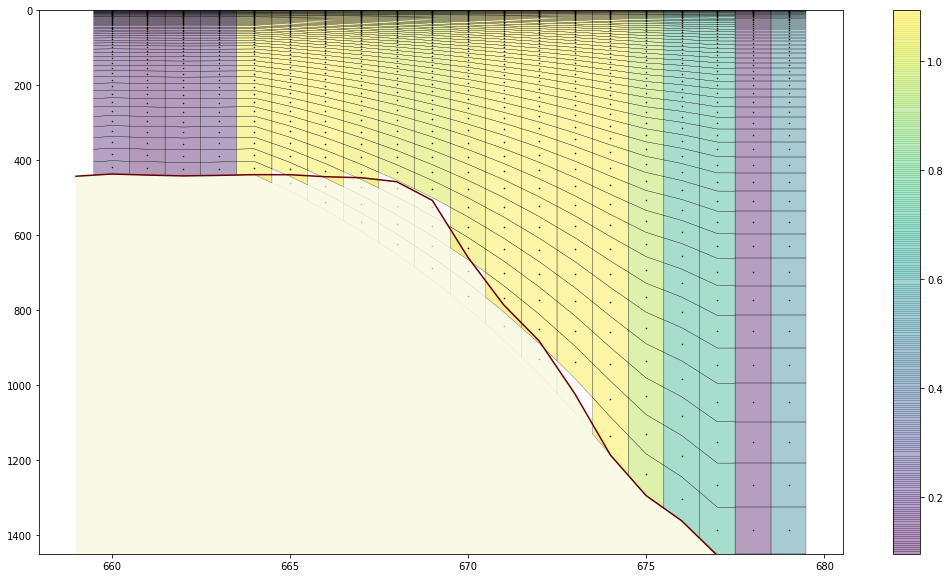

In [9]:
fig = plot_zgr('/projectsa/Eurobasin/domain_cfg_50.nc',file_bth,np.arange(3016,3017,1),np.arange(659,680,1),50,1450)

In [59]:
fig.savefig('/login/jdha/Desktop/zgr_hyb_50_A_pre.jpg')